**классификатор изображений (HOG)**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
# !pip3 install scikit-image

In [2]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

Navneet Dalal and Bill Triggs  
Histograms of Oriented Gradients for Human Detection.     
http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf


Satya Mallick  
Histogram of Oriented Gradients explained using OpenCV.      
https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

## подготовка данных

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(image_train, target_train),(image_test, target_test) = fashion_mnist.load_data()

image_train.shape, image_test.shape

((60000, 28, 28), (10000, 28, 28))

Гистограмма направленных градиентов (Histogram of Oriented Gradients, HOG)

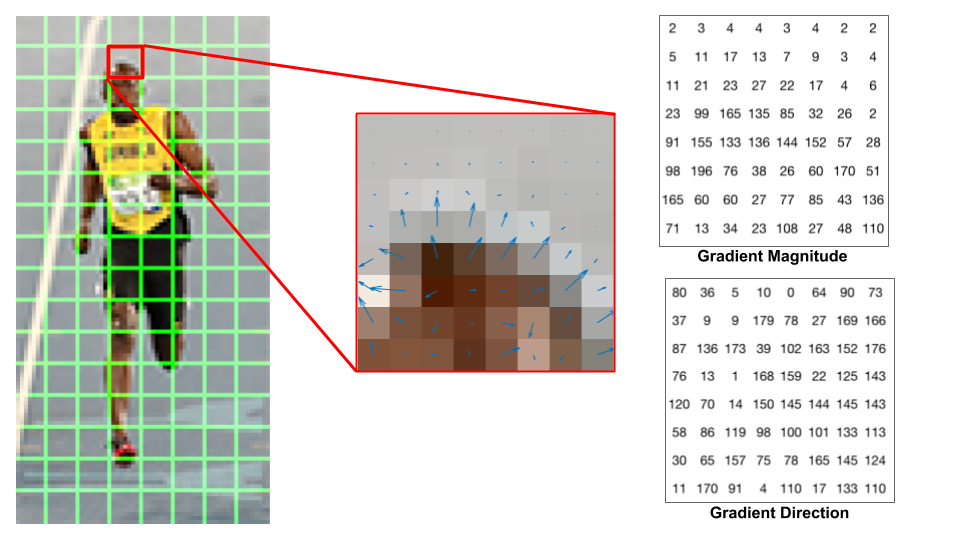

In [4]:
from skimage.feature import hog

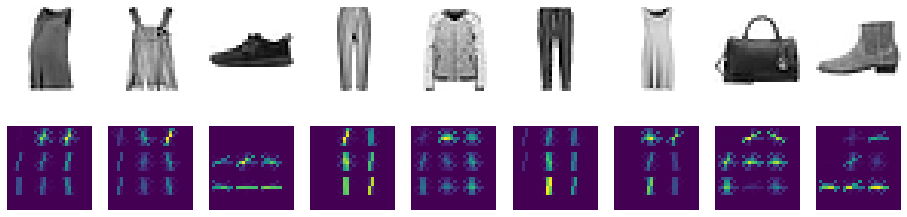

In [5]:
n_show, ppc, cpb = 9, (8,8), (2,2) # pixels per cell, cells per block

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
    img = image_train[i]
    
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.imshow(img,cmap='gray_r')

    _,hog_img = hog(img,pixels_per_cell=ppc,cells_per_block=cpb,visualize=True,)
    plt.subplot( 2, n_show, n+n_show)
    plt.axis(False)
    plt.imshow(hog_img) #,cmap='gray_r')

In [6]:
%%time

from tqdm.notebook import tqdm

X_train = np.array([ hog(x, pixels_per_cell=ppc, cells_per_block=cpb) for x in tqdm(image_train) ])
X_test  = np.array([ hog(x, pixels_per_cell=ppc, cells_per_block=cpb) for x in tqdm(image_test)  ])

X_train.shape, X_test.shape

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 15.9 s, sys: 109 ms, total: 16 s
Wall time: 16.1 s


((60000, 144), (10000, 144))

## обучение модели

In [7]:
%%time

from sklearn import svm
from sklearn.model_selection import train_test_split

X_train_, _, target_train_, _ = train_test_split( X_train, target_train, test_size=.73)
print( X_train_.shape)

model = svm.SVC().fit(X_train_,target_train_)

(16200, 144)
CPU times: user 6.64 s, sys: 7.9 ms, total: 6.65 s
Wall time: 6.77 s


## оценка результатов

In [8]:
%%time 

o_test = model.predict(X_test)

CPU times: user 11.6 s, sys: 0 ns, total: 11.6 s
Wall time: 11.6 s


In [9]:
class_names = [ 
    'футболка', 
    'брюки', 
    'свитер', 
    'платье', 
    'пальто', 
    'сандали', 
    'рубашка', 
    'тапки', 
    'сумка', 
    'полусапожки', 
    ]

In [10]:
from sklearn.metrics import classification_report

print(classification_report(target_test, o_test, target_names=class_names) ) 

              precision    recall  f1-score   support

    футболка       0.78      0.82      0.80      1000
       брюки       0.97      0.95      0.96      1000
      свитер       0.73      0.72      0.72      1000
      платье       0.84      0.85      0.84      1000
      пальто       0.70      0.75      0.72      1000
     сандали       0.93      0.92      0.93      1000
     рубашка       0.57      0.51      0.54      1000
       тапки       0.89      0.91      0.90      1000
       сумка       0.96      0.96      0.96      1000
 полусапожки       0.95      0.95      0.95      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



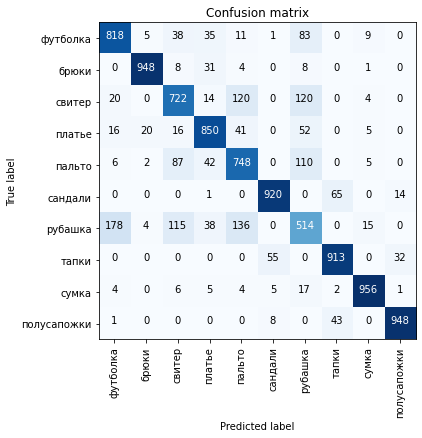

In [11]:
# матрица ошибок
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test,o_test)

classes=class_names
thresh = cm.max()/2.
tick_marks = np.arange(len(classes))

fig = plt.figure(figsize=(6,6))
plt.title('Confusion matrix')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    c = 'white' if cm[i,j] > thresh else 'black'
    plt.text(j,i, f'{cm[i,j]}',horizontalalignment="center",color=c)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

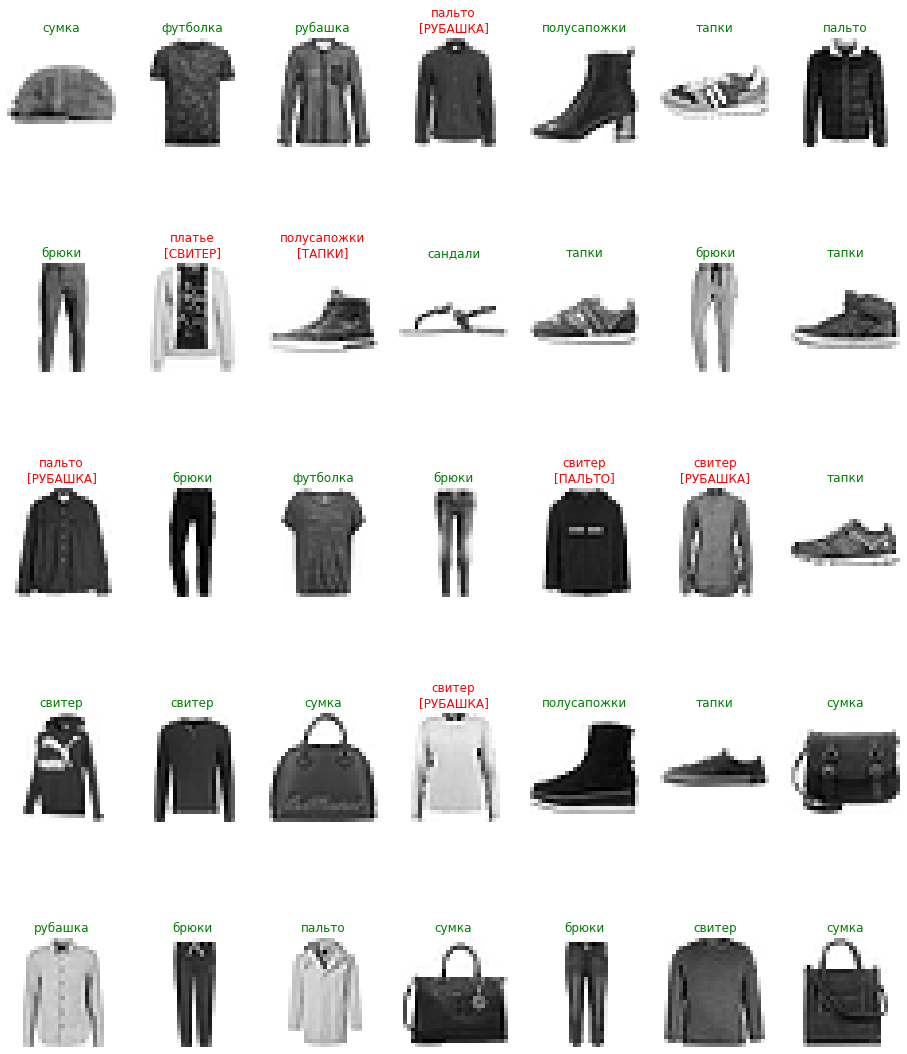

In [12]:
n_show, n_cols = 35, 7

n_rows = np.ceil(n_show/n_cols).astype(int)

plt.figure(figsize=(16,4*n_rows,))
for n,i in enumerate( rng.permutation(len(image_test))[:n_show] ):
    img = image_test[i]
    
    er = target_test[i]==o_test[i]
    t_mark = class_names[target_test[i]] 
    t_pred = class_names[o_test[i]] 
    t,c = (t_mark,'g') if er else (f'{t_pred}\n[{t_mark.upper()}]','r')
   
    plt.subplot(n_rows,n_cols,n+1)
    plt.axis(False)
    plt.title(t,color=c)
    plt.imshow(img,cmap='gray_r')


In [13]:
# !mkdir -p ../data/fashion-mnist
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

# # http://yann.lecun.com/exdb/mnist/
# import gzip
# import idx2numpy

# def ar2im(x): return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)

# DATASET_FOLDER = 'fashion-mnist'

# with gzip.open( DATASET_FOLDER+'/train-images-idx3-ubyte.gz','rb') as f:
#     image_train = idx2numpy.convert_from_string(f.read())
    
# with gzip.open( DATASET_FOLDER+'/train-labels-idx1-ubyte.gz','rb') as f:
#     target_train = idx2numpy.convert_from_string(f.read())

# with gzip.open( DATASET_FOLDER+'/t10k-images-idx3-ubyte.gz','rb') as f:
#     image_test = idx2numpy.convert_from_string(f.read())
    
# with gzip.open( DATASET_FOLDER+'/t10k-labels-idx1-ubyte.gz','rb') as f:
#     target_test = idx2numpy.convert_from_string(f.read())

# image_train.shape, image_test.shape